# Exercises Day05

In [5]:
#%load_ext autoreload
#%autoreload 2

import numpy as np
import scipy 
import matplotlib.pyplot as plt
#from helperfunction import *



## Ex01
For the discrete case we choose a proposal distribution that is simply bernoulli ditribution that is either $\Delta X[-1,1]$. The normalization constant $c$ is found by solving the equation

$$
\sum_{i=0}^m c\frac{A^i}{i!} = 1 \Leftrightarrow c = \frac{1575}{3830591}
$$

In [6]:
m = 10
MCMC_iter = 10**5
service_mean = 8
arrival_mean = 1

random_ass_number = 1575 / 3830591  # <-- Alex found this with Maple-Magic
A = service_mean * arrival_mean

g = lambda x: (A**x) / (np.math.factorial(x) )
f = lambda x: (random_ass_number * A**x)/ scipy.special.factorial(x)#(np.exp(-A) * A**x)/ scipy.special.factorial(x) 

def MCMC(num_samples : int, X_0: int = None, burn_in_ratio : float = 0.5):
    """
        Markov Chain Monte Carlo scheme. We use the Metropolis-Hastings algorithm.
        NOTE: The burn_in_ratio is added to the amount samples. I.e. the number of iterations
        are num_samples * (1 + burn_in_ratio).
        
        :param num_samples: Number of samples points from the MCMC
        :param X_0: Initial value of the Markov Chain. If None, a random value between 0 and m is chosen.
        :param burn_in_ratio: The amount of burn-in we wish to apply (as a ratio)
        
        :return: Samples from the Markov Chain
    """
    num_iter = int(num_samples * (1 + burn_in_ratio))
    if X_0 is None:
        X_0 = np.random.randint(0, m + 1) # Random number between 0 and m (inclusive)

    samples = []
    samples.append(X_0)

    for _ in range(num_iter):
        delta_X = np.random.binomial(n=1, p=0.5)*2 - 1 # Number either -1 or 1
        X_curr = samples[-1]
        
        X_proposal = X_curr + delta_X  # <-- okay.. this is technically unecessary, but it's good practice to initialize variables (that would otherwise go out of scope)
        
    
        if X_proposal < 0:
            # Edge-case lower end
            X_proposal = m
        elif X_proposal > m:
            # Edge-case upper end
            X_proposal = 0 
            

        A = min(1.0, g(X_proposal) / g(X_curr))
        

        accept = np.random.binomial(n=1, p=A)
      
        if accept:
            samples.append(X_proposal)
        elif not accept:
            samples.append(X_curr)

    
    return samples[num_samples:]
        

Count of sampled points: [   7   40  159  426  763 1149 1468 1656 1639 1462 1232]


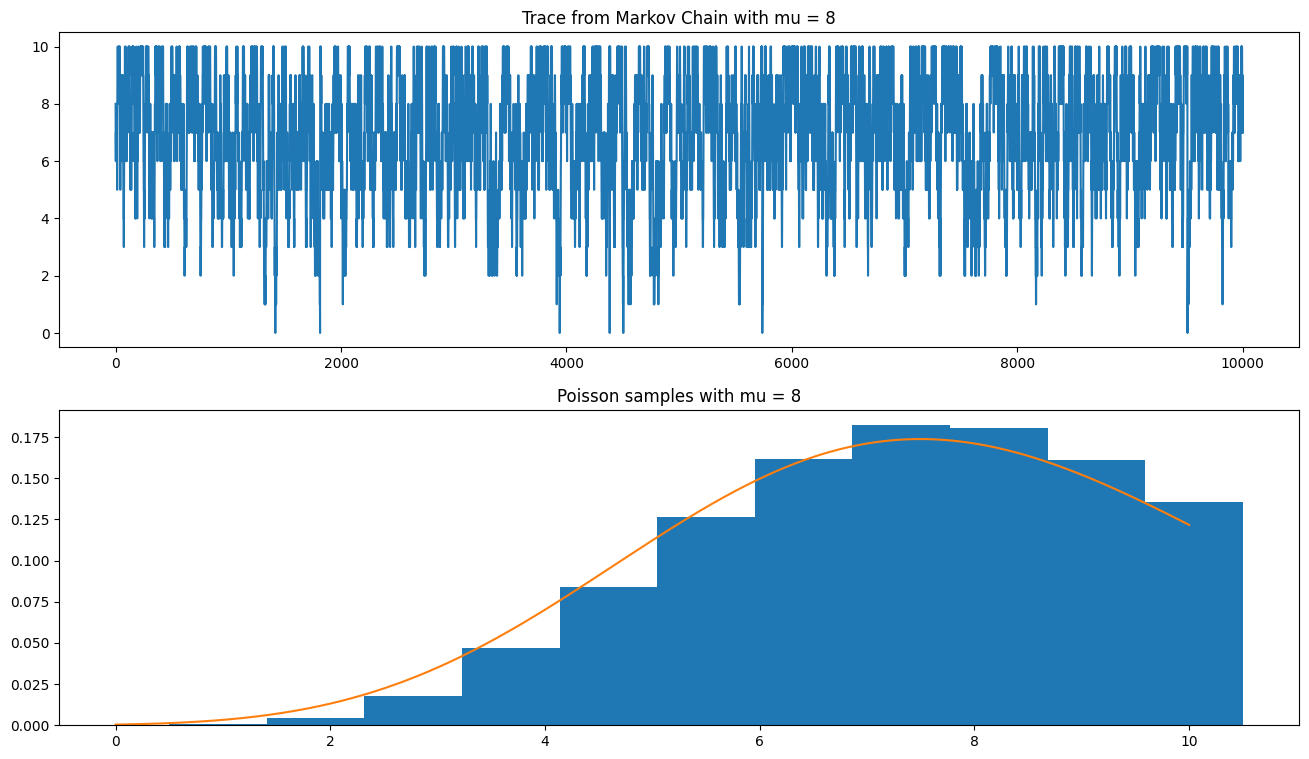

In [7]:
pois_samples = MCMC(MCMC_iter, burn_in_ratio=0.1)

# print(f"Poisson samples: \n{pois_samples}")
print(f"Count of sampled points: {np.histogram(pois_samples, bins = m + 1)[0]}")

# Plotting
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.plot(pois_samples)
plt.title(f"Trace from Markov Chain with mu = {A}")

plt.subplot(2, 1, 2)
XX = np.linspace(0, m, 1000)
Y = f(XX)
plt.title(f"Poisson samples with mu = {A}")
plt.hist(np.array(pois_samples) + 1/2, bins=m+1, density = True)
plt.plot(XX, Y)

plt.show()

$Chi^2$-test

In [8]:
def chi_squared_test_pois(pois : list[float], num_bins : int) -> float:
    """
        This function performs the chi-squared test on a list of random numbers.
        For poisson distribution.
        
        :param U: list of random numbers (uniformly distributed).
        :param num_bins: number of bins to divide the random numbers into.
                        y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
        :return p: returns the p-value of the test.
    """
    
    expected_num_in_bins = f(np.arange(0, num_bins + 1))
    
    # Divied into bins
    counts, _ = np.histogram(pois, bins=num_bins+1)
    counts = counts / len(pois)

    T = np.abs(np.sum((counts - expected_num_in_bins)**2 / expected_num_in_bins))
    df = num_bins -1 -1 # when number of estimated parameters is m=1
    
    p = 1 - scipy.stats.chi2.cdf(T, df)
    
    return p

chi_test = chi_squared_test_pois(pois_samples, m)
print(chi_test)

0.99999999999939


## Ex02
The normalization constant for the two dimensional case becomes
$$
\sum_{i=0}^m\sum_{j=10-i}^m c\frac{A_1^i}{i!}\frac{A_2^j}{j!} = 1 \Leftrightarrow c = \frac{1575}{3830591}
$$
It makes sense that the normalization constant is the same as for the previous as it is the same distribution but where $x=i+j$. 

### a) simply Metropolis-Hastings
we handle both dimensions at a time

In [9]:
m = 10
MCMC_iter = 10**5

random_ass_number =  1575 / 3830591
A1 = 4
A2 = 4

g2 = lambda x: A1**x[0] / np.math.factorial(x[0])  * A2**x[1] / np.math.factorial(x[1])
f2 = lambda x: (random_ass_number * A**x)/ scipy.special.factorial(x)#(np.exp(-A) * A**x)/ scipy.special.factorial(x) 

def MCMC_two_dim(num_samples : int, X_0: int = None, burn_in_ratio : float = 0.5):
    """
        Markov Chain Monte Carlo scheme. We use the Metropolis-Hastings algorithm.
        This is for the two-dimensional case.
        NOTE: The burn_in_ratio is added to the amount samples. I.e. the number of iterations
        are num_samples * (1 + burn_in_ratio).
        
        :param num_samples: Number of samples points from the MCMC
        :param X_0: Initial value of the Markov Chain. If None, a random value between 0 and m is chosen.
        :param burn_in_ratio: The amount of burn-in we wish to apply (as a ratio)
        
        :return: Samples from the Markov Chain
    """
    
    num_iter = int(num_samples * (1 + burn_in_ratio))
    if X_0 is None:
        temp = np.random.randint(0, m + 1)
        X_0 = np.array([temp,np.random.randint(0, 10 - temp + 1)]) # [Random number between 0 and m (inclusive), Random number between 0 and 10 - previously sampled number (inclusive)]
  
    samples = []
    samples.append(X_0)

    for _ in range(num_iter):

        delta_X = np.random.binomial(n=1, p=0.5, size=2)*2 - 1 # Number either -1 or 1
        X_curr = samples[-1]
         
        X_proposal =  X_curr + delta_X
        
        
        if (X_curr.sum() == m or X_curr.sum() == m - 1) and delta_X.sum() == 2:
            # If we try to move beyond i + j = m, we stay at the same point
            biggest_indx = np.argmax(X_proposal)
            X_proposal[biggest_indx] = 0
            X_proposal[1 - biggest_indx] = (X_curr[biggest_indx] - X_curr[1 - biggest_indx]) % m+1 # <-- a*x + b = y 
            print(X_proposal, "diagonal edge case")
        
        if X_curr[0] == 0 and delta_X[0] == -1:
            # Edge-case lower end
            X_proposal[0] = 10 - X_curr[1]
            print(X_proposal, "X edge case")
            
        if X_curr[1] == 0 and delta_X[1] == -1:
            # Edge-case lower end
            X_proposal[1] = 10 - X_curr[0]
            print(X_proposal, "Y edge case")
         
        
        A = min(1, g2(X_proposal) / g2(X_curr))
        accept = np.random.binomial(n=1,p=A)
 
        if accept:
            samples.append(X_proposal)
        elif not accept:
            samples.append(X_curr)

    
    return samples[num_samples:]
        

pois_samples2 = np.array(MCMC_two_dim(MCMC_iter, burn_in_ratio=0.1))

print(pois_samples2.shape)
# print(f"Poisson samples: \n{pois_samples}")
print(f"Count of sampled points: {np.histogram(pois_samples2, bins = m + 1)[0]}")

# Plotting
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.plot(pois_samples2.sum(axis=1))
plt.title(f"Trace from Markov Chain with mu = {A}")

plt.subplot(2, 1, 2)
XX = np.linspace(0, m, 1000)
Y = f(XX)
plt.title(f"Poisson samples with mu = {A}")
plt.hist(np.array(pois_samples2.sum(axis = 1)), bins = (m + 1), density = True)
plt.plot(XX, Y)

plt.show()



[7 4] X edge case
[2 0] diagonal edge case
[2 0] diagonal edge case
[2 0] diagonal edge case
[4 7] Y edge case
[6 0] diagonal edge case
[6 0] diagonal edge case
[0 2] diagonal edge case
[0 2] diagonal edge case
[2 0] diagonal edge case
[4 0] diagonal edge case
[4 0] diagonal edge case
[6 0] diagonal edge case
[6 0] diagonal edge case
[8 0] diagonal edge case
[3 6] X edge case
[0 9] Y edge case
[0 6] diagonal edge case
[4 5] X edge case
[2 0] diagonal edge case
[4 0] diagonal edge case
[6 0] diagonal edge case
[2 0] diagonal edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[6 3] X edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[0 2] diagonal edge case
[0 2] diagonal edge case
[0 2] diagonal edge case
[0 2] diagonal edge case
[0 2] diagonal edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[0 2] diagonal edge case
[0 2] diagonal edge case
[7 2] X edge case
[0 4] diagonal edge case

ValueError: Integers to negative integer powers are not allowed.

[ 7 -1] out of bounds
[5 6] out of bounds
[5 6] out of bounds
[5 6] out of bounds
[5 6] out of bounds
[6 5] out of bounds
[5 6] out of bounds
[7 5] out of bounds
[7 4] out of bounds
[5 6] out of bounds
[5 6] out of bounds
[4 8] out of bounds
[3 8] out of bounds
[4 7] out of bounds
[-1  3] out of bounds
[4 8] out of bounds
[3 8] out of bounds
[4 8] out of bounds
[2 9] out of bounds
[2 9] out of bounds
[2 9] out of bounds
[2 9] out of bounds
[-1  7] out of bounds
[-1  7] out of bounds
[-1  9] out of bounds
[-1 10] out of bounds
[-1 11] out of bounds
[-1  9] out of bounds
[ 1 10] out of bounds
[3 9] out of bounds
[3 9] out of bounds
[3 9] out of bounds
[2 9] out of bounds
[3 8] out of bounds
[4 7] out of bounds
[4 7] out of bounds
[7 4] out of bounds
[ 5 -1] out of bounds
[ 6 -1] out of bounds
[ 4 -1] out of bounds
[ 6 -1] out of bounds
[6 5] out of bounds
[5 6] out of bounds
[ 4 -1] out of bounds
[-1  5] out of bounds
[-1  4] out of bounds
[-1  2] out of bounds
[-1  4] out of bounds
[2 9

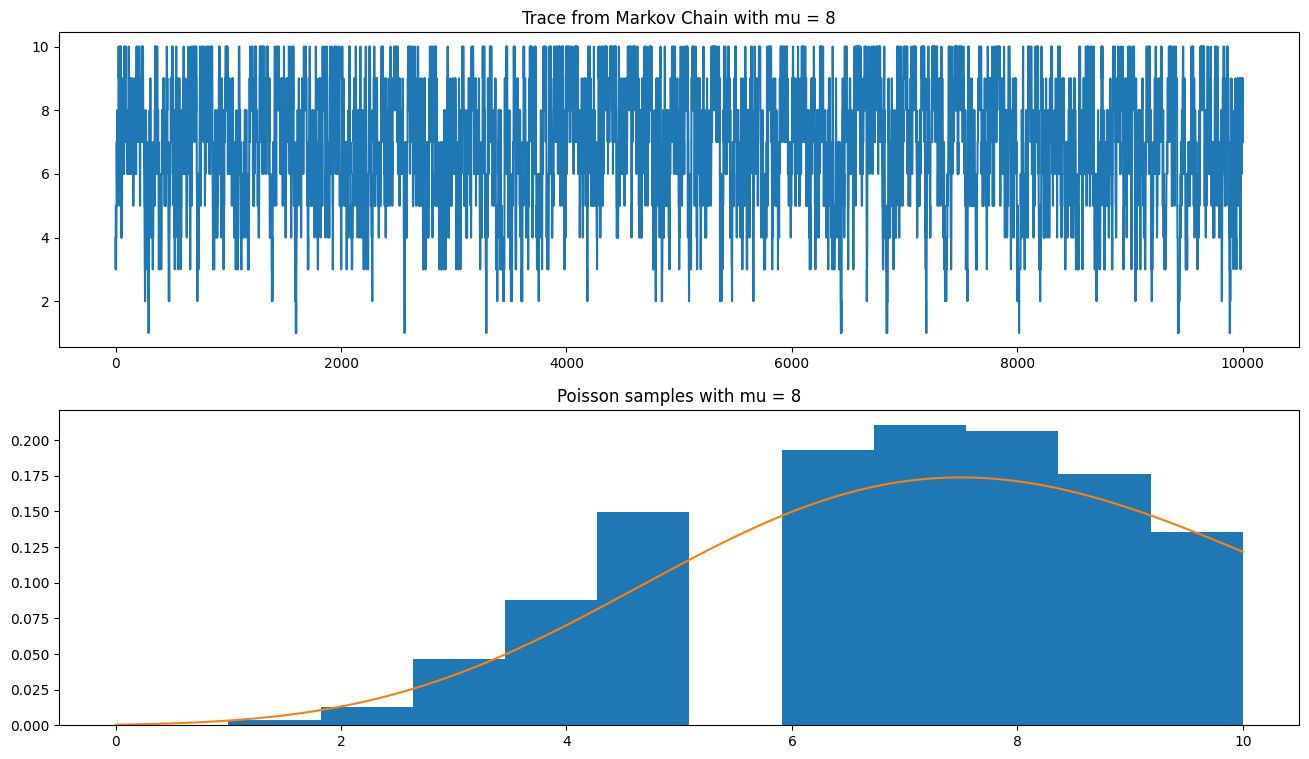

In [11]:
m = 10
MCMC_iter = 10**5

random_ass_number =  1575 / 3830591
A1 = 4
A2 = 4

g2 = lambda x: A1**x[0] / np.math.factorial(x[0])  * A2**x[1] / np.math.factorial(x[1])
f2 = lambda x: (random_ass_number * A**x)/ scipy.special.factorial(x)#(np.exp(-A) * A**x)/ scipy.special.factorial(x) 

def MCMC_two_dim_boxed(num_samples : int, X_0: int = None, burn_in_ratio : float = 0.5):
    """
        Markov Chain Monte Carlo scheme. We use the Metropolis-Hastings algorithm.
        This is for the two-dimensional case.
        NOTE: The burn_in_ratio is added to the amount samples. I.e. the number of iterations
        are num_samples * (1 + burn_in_ratio).
        
        :param num_samples: Number of samples points from the MCMC
        :param X_0: Initial value of the Markov Chain. If None, a random value between 0 and m is chosen.
        :param burn_in_ratio: The amount of burn-in we wish to apply (as a ratio)
        
        :return: Samples from the Markov Chain
    """
    
    num_iter = int(num_samples * (1 + burn_in_ratio))
    if X_0 is None:
        temp = np.random.randint(0, m + 1)
        X_0 = np.array([temp, np.random.randint(0, 10 - temp + 1)]) # [Random number between 0 and m (inclusive), Random number between 0 and 10 - previously sampled number (inclusive)]
  
    samples = []
    samples.append(X_0)

    for _ in range(num_iter):
        
        delta_X = np.random.randint(-1, 2, size=2)
        while delta_X[0] == 0 and delta_X[1] == 0:
            delta_X = np.random.randint(-1, 2, size=2)
        X_curr = samples[-1]
         
        X_proposal =  X_curr + delta_X
        
        if X_proposal.sum() > m or X_proposal[0] < 0 or X_proposal[1] < 0:
            print(X_proposal, "out of bounds")
            samples.append(X_curr)
            
        else:
            A = min(1, g2(X_proposal) / g2(X_curr))
            accept = np.random.binomial(n=1, p=A)
    
            if accept:
                samples.append(X_proposal)
            elif not accept:
                samples.append(X_curr)

    
    return samples[num_samples:]
        

pois_samples2 = np.array(MCMC_two_dim_boxed(MCMC_iter, burn_in_ratio = 0.1))

print(pois_samples2.shape)
print(f"Count of sampled points: \n{np.histogram(pois_samples2.sum(axis = 1), bins = (m + 1))[0]}")
print(set(pois_samples2.sum(axis = 1)))

# Plotting
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.plot(pois_samples2.sum(axis=1))
plt.title(f"Trace from Markov Chain with mu = {A}")

plt.subplot(2, 1, 2)
plt.hist(np.array(pois_samples2.sum(axis = 1)), bins = (m + 1), density = True)
XX = np.linspace(0, m, 1000)
Y = f(XX)
plt.plot(XX, Y)
plt.title(f"Poisson samples with mu = {A}")

plt.show()



$Chi^2$ test

In [172]:
def chi_squared_test_pois(pois : list[float], num_bins : int) -> float:
    """
        This function performs the chi-squared test on a list of random numbers.
        For poisson distribution.
        
        :param U: list of random numbers (uniformly distributed).
        :param num_bins: number of bins to divide the random numbers into.
                        y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
        :return p: returns the p-value of the test.
    """
    
    expected_num_in_bins = f(np.arange(0, num_bins + 1))
    
    
    # Divied into bins
    counts, _ = np.histogram(pois, bins=num_bins+1)
    counts = counts / len(pois)

    T = np.abs(np.sum((counts - expected_num_in_bins)**2 / expected_num_in_bins))
    df = num_bins -1 -1 # when number of estimated parameters is m=1
    
    p = 1 - scipy.stats.chi2.cdf(T, df)
    
    return p

chi_test = chi_squared_test_pois(pois_samples2.sum(axis=1), m)
print(chi_test)

0.9999999371163824


### b) Metropolis-Hastings, coordinate wise
We accept/reject one dimension at a time


In [ ]:
m = 10
MCMC_iter = 10**3

random_ass_number =  1575 / 3830591
A1 = 4
A2 = 4

g2 = lambda x: A1**x[0] / np.math.factorial(x[0])  * A2**x[1] / np.math.factorial(x[1])
f2 = lambda x: (random_ass_number * A**x)/ scipy.special.factorial(x)#(np.exp(-A) * A**x)/ scipy.special.factorial(x) 

def MCMC_two_coordinate(num_iter : int, X_0: int = None, burn_in_ratio : float = 0.5):
    """
        Markov Chain Monte Carlo scheme. We use the Metropolis-Hastings algorithm.
        
        :param num_iter: Number of iterations
        :param X_0: Initial value of the Markov Chain. If None, a random value between 0 and m is chosen.
        :param burn_in_ratio: The amount of burn-in we wish to apply (as a ratio)
        
        :return: Samples from the Markov Chain
    """
    
    sample_num = int(num_iter * (1 + burn_in_ratio))
    if X_0 is None:
        temp = np.random.randint(0, m + 1)
        X_0 = np.array([temp,np.random.randint(0, 10 - temp + 1)]) # [Random number between 0 and m (inclusive), Random number between 0 and 10 - previously sampled number (inclusive)]
  
    samples = []
    samples.append(X_0)

    for _ in range(sample_num):
        X_curr = samples[-1]
        
        for i in range(2):
            delta_X = np.random.binomial(n=1, p=0.5, size=2)*2 - 1 # Number either -1 or 1
            
            
            X_proposal = X_curr + delta_X 
            if X_curr[0] == 0 and delta_X[0] == -1:
                # Edge-case lower end
                X_proposal[0] = 0
                
            if X_curr[1] == 0 and delta_X[1] == -1:
                # Edge-case lower end
                X_proposal[1] = 0

            elif (X_curr.sum() == m or X_curr.sum() == m - 1) and delta_X.sum() == 2:
                # If we try to move beyond i + j = m, we stay at the same point
                X_proposal =  X_curr
        
            
            A = min(1, g(X_proposal) / g(X_curr))
            accept = np.random.binomial(n=1,p=A)
    
            if accept:
                samples.append(X_proposal)
            elif not accept:
                samples.append(X_curr)

    
    return samples[:num_iter]
        

pois_samples = np.array(MCMC_two_dim(MCMC_iter, burn_in_ratio=0.1))


print(f"Poisson samples: \n{pois_samples}")

# Plotting
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.plot(pois_samples.sum(axis=1))
plt.title(f"Trace from Markov Chain with mu = {A}")

plt.subplot(2, 1, 2)
XX = np.linspace(0, m, 1000)
Y = f(XX)
#plt.figure(figsize=(16, 9))
plt.title(f"Poisson samples with mu = {A}")
plt.hist(np.array(pois_samples.sum(axis=1)), density=True)
plt.plot(XX, Y)

plt.show()

### c)

The conditional distribution is found by

$$
\begin{align*}
p(i|j) &= \frac{P(i,j)}{p(j)} \\
       &= \frac{P(i,j)}{\sum_{j}p(i,j)} \\
       &= \frac{c\frac{A_1^i}{i!}\frac{A_2^j}{j!}}{\sum_{j} c\frac{A_1^i}{i!}\frac{A_2^j}{j!}} \\
\end{align*}
$$

## Ex03


### a)


In [165]:
rho = 0.5

prior_mean = np.array([0,0])
prior_cov = np.array([[1,0.5],[0.5,1]])

sample_prior = scipy.stats.multivariate_normal.rvs(prior_mean,prior_cov)
pair_post = np.exp(sample_prior)

print(pair_post)

[0.07995327 0.37345712]


### b)


In [166]:
n = 10
post_samples = scipy.stats.norm.rvs(pair_post[0],pair_post[1],size = n)

print(post_samples)


[ 0.50661992 -0.0005392   0.27866419  0.27471161  0.02501488  0.27744456
 -0.06694388 -0.1786771  -0.48868678  0.16278329]


### c)
